# This notebook shows training of new birth networks.

set work directory to the "Single_Particle_Tracking" folder

download and upzip [data and intermediate results](https://drive.google.com/open?id=1AO6du609gYup2mcyKIWEqU5dH5p8Fa4K) to work directory

In [5]:
from __future__ import print_function

import keras 
from keras.datasets import mnist
from keras.models import Sequential, Model,load_model
from keras.layers import Input, Dense, Dropout, Flatten, MaxPooling3D, TimeDistributed, Conv2D, MaxPooling2D, UpSampling2D, Bidirectional, GlobalAveragePooling2D
from keras.layers.core import Dense, Dropout, Reshape, Activation
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization


%matplotlib inline
import matplotlib.pyplot as plt
from skimage import io
import random 
import numpy as np

from skimage import measure
from skimage.measure import label 
import scipy as sp
import scipy.ndimage.morphology

In [2]:
# load blury images (obs.tif) and ground truth (labels.tif)

folder = './data_and_pre_calculated_results/'

from skimage import io
obs = io.imread(folder+'obs.tif').astype('float32')
labels = io.imread(folder+'label.tif').astype('float32')
img_size = obs.shape[-1]

print(obs.shape)
print(labels.shape)

(10000, 60, 60)
(10000, 60, 60)


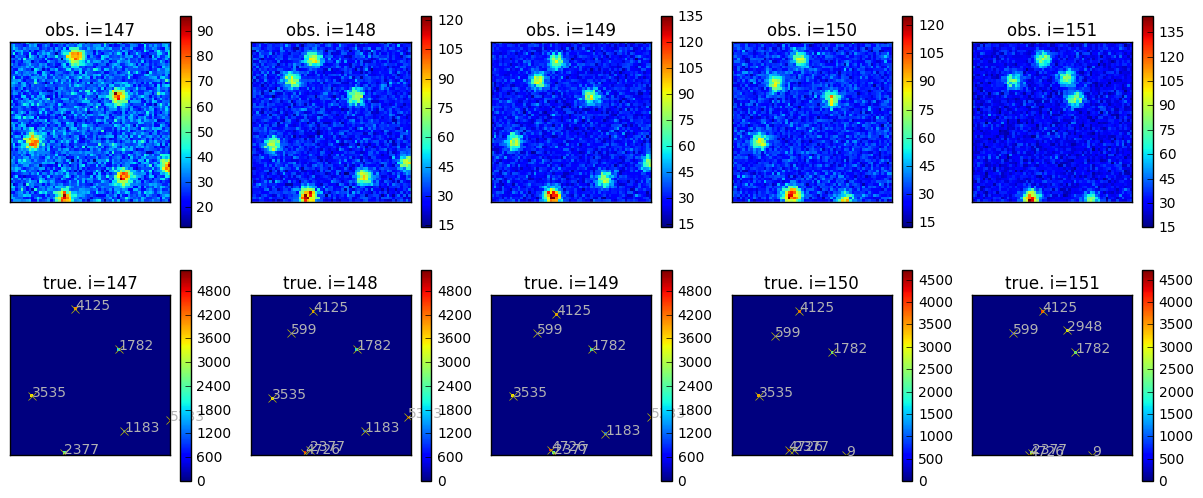

In [3]:
# plot raw data  

import random 
n = 5
i_base = random.randint(0,200)  
plt.figure(figsize=(15, 6))
for i in range(n):
 
    ax = plt.subplot(2, n, i+1)
    plt.imshow(obs[i+i_base,:,:].reshape(img_size, img_size),interpolation='none')
 
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('obs. i='+str(i+i_base))
    plt.colorbar()
    
    ax = plt.subplot(2, n, i+n+1)  
    plt.imshow(labels[i+i_base,:,:].reshape(img_size, img_size),interpolation='none')   
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('true. i='+str(i+i_base))
    plt.colorbar()
    true_idx = np.where(labels[i+i_base,:,:]!=0)
    true_idx_label = labels[i+i_base,:,:][true_idx]
    for tru in range(len(true_idx[0])):
        plt.text(true_idx[1][tru],true_idx[0][tru], str((true_idx_label[tru]).astype('int')),color=[.7,.7,.7])#color='magenta' )
        plt.plot(true_idx[1][tru],true_idx[0][tru], 'yx')
        
    plt.xlim(0,img_size-1)
    plt.ylim(img_size-1,0)
         
    
    

In [15]:
# normalize data

T_train = 9000 # number of frames chosen to train
T_all = 10000 # total number frames used (train+test)

x_train = obs[0:T_train,:,:]
x_train_before_normalization = x_train.copy() 
print(x_train.shape)
y_train = labels[0:T_train,:,:]
print(y_train.shape)

x_test = obs[T_train:T_all,:,:]
x_test_before_normalization = x_test.copy() 
print(x_test.shape)
y_test = labels[T_train:T_all,:,:]
print(y_test.shape)


x_train = x_train.astype('float32')    
x_test = x_test.astype('float32')    
 
#normalization 
for idx in range(x_train.shape[0]):
    x_train[idx,:,:] = x_train[idx,:,:]/x_train[idx,:,:].max()
 
    
for idx in range(x_test.shape[0]):
    x_test[idx,:,:] = x_test[idx,:,:]/x_test[idx,:,:].max()
 


(9000, 60, 60)
(9000, 60, 60)
(1000, 60, 60)
(1000, 60, 60)


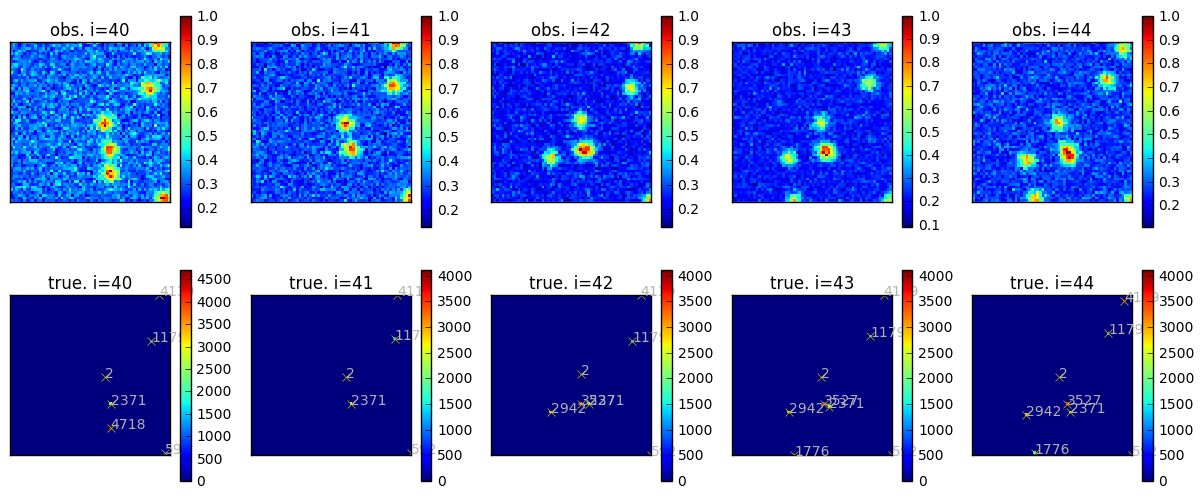

In [7]:
# plot data after normalization
import random 
n = 5
i_base = random.randint(0,200)  
plt.figure(figsize=(15, 6))
for i in range(n):
 
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_train[i+i_base,:,:].reshape(img_size, img_size),interpolation='none')
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('obs. i='+str(i+i_base))
    plt.colorbar()
    
    ax = plt.subplot(2, n, i+n+1)  
    plt.imshow(y_train[i+i_base,:,:].reshape(img_size, img_size),interpolation='none')     
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('true. i='+str(i+i_base))
    plt.colorbar()
    true_idx = np.where(labels[i+i_base,:,:]!=0)
    true_idx_label = labels[i+i_base,:,:][true_idx]
    for tru in range(len(true_idx[0])):
        plt.text(true_idx[1][tru],true_idx[0][tru], str((true_idx_label[tru]).astype('int')),color=[.7,.7,.7])#color='magenta' )
        plt.plot(true_idx[1][tru],true_idx[0][tru], 'yx')
        
    plt.xlim(0,img_size-1)
    plt.ylim(img_size-1,0)
         
    
    

# prepare NN input and output for New Birth Networks

In [16]:
# takes a while. you can load the pre-run NN input and output 
''' 
NN_inputs = np.load(folder+'NN_inputs_newbirth.npy')
print(NN_inputs.shape)
NN_outputs = np.load(folder+'NN_outputs_newbirth.npy')
print(NN_outputs.shape)
'''

Ntrain = x_train.shape[0]-2 

NN_inputs = np.zeros([Ntrain, 6, img_size, img_size, 1])  
NN_outputs = np.zeros([Ntrain, img_size, img_size, 1])  

for t in range(2,x_train.shape[0]-2):
    
    if t%1000==0:
        print(t)
    images = x_train[t-2:t+3,:,:]
    
    
    current_unique_values = np.unique(y_train[t,:,:])[1:]
    new_borns = []
    sampled_id = []
    new_borns_img = np.zeros([img_size, img_size])
    sampled_mask = np.zeros([img_size, img_size])
    for i in range(len(current_unique_values)):
        if len(np.where(y_train[:t,:,:] == current_unique_values[i])[0])==0:
            new_borns = np.append(new_borns, current_unique_values[i])
        
            var = new_borns_img[np.where(y_train[t,:,:] == current_unique_values[i])]
            if var != 0: 
                raise('var is not zero: more than one particles in the pixel, t=%d, i=%d'%(t,i))
            new_borns_img[np.where(y_train[t,:,:] == current_unique_values[i])] = 1
        
        else:
            var_sampled = sampled_mask[np.where(y_train[t,:,:] == current_unique_values[i])]
            sampled_id = np.append(sampled_id, current_unique_values[i])
            if var_sampled != 0: 
                raise('var_sampled is not zero: more than one particles in the pixel, t=%d, i=%d'%(t,i))
            sampled_mask[np.where(y_train[t,:,:] == current_unique_values[i])] = 1
            
            
    sampled_mask_concat = np.expand_dims(sampled_mask, axis=0)
    new_borns_img_concat = np.expand_dims(new_borns_img, axis=0)
    
    inputs = np.concatenate((images, sampled_mask_concat), axis=0)
    NN_inputs[t,:,:,:,0] = inputs   
    NN_outputs[t,:,:,0] = new_borns_img 
    
         

1000
2000
3000
4000
5000
6000
7000
8000


In [17]:
print(NN_outputs.shape)
print(NN_inputs.shape)

(8998, 60, 60, 1)
(8998, 6, 60, 60, 1)


In [ ]:
NN_outputs1 = np.expand_dims(NN_outputs, axis=1)  # extend a dimension for NN input
NN_outputs1.shape

In [ ]:
np.save(folder+'NN_inputs_newbirth',NN_inputs)
np.save(folder+'NN_outputs_newbirth',NN_outputs1)

#NN_inputs = np.load(folder+'NN_inputs_newbirth.npy')
#NN_outputs = np.load(folder+'NN_outputs_newbirth.npy')

# plot NN input and output

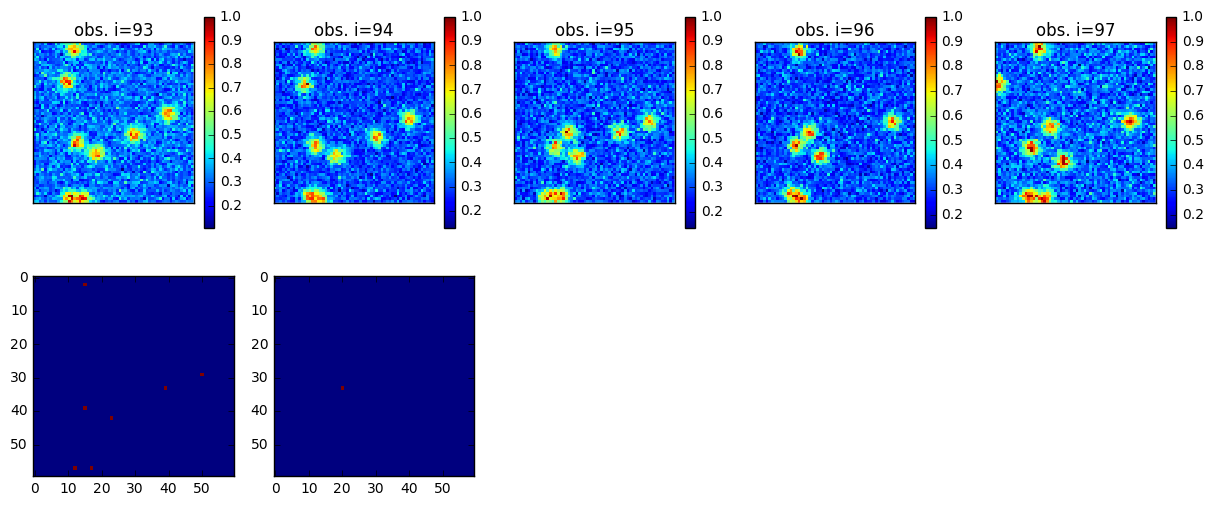

In [14]:
# visualize neural networks input and output (for debug)
import random 
img_size = 60
n = 5
i_base = random.randint(0,100)  
plt.figure(figsize=(15, 6))
for i in range(n):
 
    
    ax = plt.subplot(2, n, i+1)
    plt.imshow(NN_inputs[i_base,i,:,:,0].reshape(img_size, img_size),interpolation='none')
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title('obs. i='+str(i+i_base))
    plt.colorbar()
    
    
    
    ax = plt.subplot(2, n, n+1)
    plt.imshow(NN_inputs[i_base,5,:,:,0].reshape(img_size, img_size),interpolation='none')
 
    ax = plt.subplot(2, n, 2+n)
    plt.imshow(NN_outputs[i_base,:,:,0].reshape(img_size, img_size),interpolation='none')  
        
    

# Build NN Architecture

the same as conditional probabilty networks

In [6]:
# build graph 
 
nfeatures = 6
seq = Sequential()


############################ Layer 1 : bidirectional ConvLSTM 2D #########################################
seq.add(Bidirectional(ConvLSTM2D(filters=32, kernel_size=(3, 3),
                   input_shape=(nfeatures, None, None, 1),
                   padding='same', return_sequences=True), name='Layer1', 
                      input_shape=(nfeatures, None, None, 1)))
# assume 10 samples. size: 10-5-28-28-64 (32 filters, concatenate forward and backward LSTM into 64)
# Note: without "Bidirectional wrapper": the output size is 10-5-28-28-32

# normalization: 
seq.add(BatchNormalization(name='Layer1_normalization'))
 

# dropout: (to prevent overfitting)
seq.add(Dropout(0.25, name='Layer1_dropout'))

############################  Layer 2: bidirectional ConvLSTM 2D ############################# 
seq.add(Bidirectional(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True),name='Layer2',input_shape=(None, None, None, 1)))
seq.add(BatchNormalization())
seq.add(Dropout(0.3))
 

############################  Layer 3: bidirectional ConvLSTM 2D ############################# 
seq.add(Bidirectional(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True),name='Layer3'))
seq.add(BatchNormalization())
seq.add(Dropout(0.3))
 

############################  Layer 4: bidirectional ConvLSTM 2D #############################
seq.add(Bidirectional(ConvLSTM2D(filters=40, kernel_size=(3, 3),
                   padding='same', return_sequences=True),name='Layer4'))
seq.add(BatchNormalization())
seq.add(Dropout(0.3))
 

############################  Layer 5: Conv3D #############################
seq.add(Conv3D(filters=256, kernel_size=(3, 3, 3),
               activation='sigmoid',
               padding='same', data_format='channels_last', name='Layer5'))
 

#dropout
seq.add(Dropout(0.3, name='Layer5-dropout'))
 

############################  Layer 6: Conv3D #############################
seq.add(Conv3D(filters=(64), kernel_size=(3, 3, 3),activation='sigmoid',
               padding='same', data_format='channels_last', name='Layer8'))

seq.add(Conv3D(filters=(1), kernel_size=(3, 3, 3),activation='sigmoid',
               padding='same', data_format='channels_last', name='Layer9'))
 
seq.add(MaxPooling3D(pool_size=(8, 1, 1), strides=None, padding='valid'))

 

# initiate RMSprop optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

# Let's train the model using RMSprop
seq.compile(loss='binary_crossentropy',
              optimizer=opt,
             metrics=['accuracy'])


In [7]:
seq.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer1 (Bidirectional)       (None, 6, None, None, 64) 76288     
_________________________________________________________________
Layer1_normalization (BatchN (None, 6, None, None, 64) 256       
_________________________________________________________________
Layer1_dropout (Dropout)     (None, 6, None, None, 64) 0         
_________________________________________________________________
Layer2 (Bidirectional)       (None, 6, None, None, 80) 299840    
_________________________________________________________________
batch_normalization_4 (Batch (None, 6, None, None, 80) 320       
_________________________________________________________________
dropout_4 (Dropout)          (None, 6, None, None, 80) 0         
_________________________________________________________________
Layer3 (Bidirectional)       (None, 6, None, None, 80) 345920    
__________

In [ ]:
# start to train
seq.fit(NN_inputs, NN_outputs1, batch_size=10, epochs=10, validation_split=0.05)

In [ ]:
# save trained model
seq.save(folder+'birth_networks.h5', 'birth_networks.h5')